# Machine Learning in Python - Group Project 2

Github link: https://github.com/monicasteph97/mlp-project-2-group-45

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules that are necessary. use sklearn==1.2.1
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler

# Other modules that are necessary
from datetime import datetime, timedelta
from pandasql import sqldf
import requests
import warnings
import time

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.set_theme(style='darkgrid')
%matplotlib inline
pd.options.display.max_columns = 200
pd.options.display.max_rows = 20

# Others
warnings.filterwarnings('ignore')
# set_config(transform_output='pandas')

In [2]:
# Load data
data = pd.read_csv('hotel.csv')

## 1. Introduction

**[TBU]** The aim of this project to advise NBC Universal on how to create the best reunion episode for the world's famous sitcom The Office (US). To do this we will explore and outline factors that make an episode popular. Namely, using the episode's IMDB rating as a basis to measure popularity and exploring different factors affecting it, such as which director, number of words spoken and main characters will produce a mroe popular episode. We will then build an understandable and validated model for the IMBD rating as the outcome of interest using features from 'the_office.csv' and 'guest_duration_office.csv'. 

From the 'guest_duration.csv' file we added the following parameters to our dataframe:

1. Viewership - The live viewership when the episode aired. We included this because we found it has a strong correlation to IMDB rating.
2. GuestStars - A list of any guest stars in the episode. We included this to explore any guest stars that have a strong impact on the IMBD rating. We can then add a recommendation to NBC for any beloved guest stars to include in the reunion episode.
3. Duration - The length of the episode. This was added as we can easily find an optimal epsiode duration to recommend to NBC.

The breakdown of the report is as follows:

- [**Section 2: Exploratory data analysis and feature engineering:**](#2) The objective of this section is to explore the data. This includes finding correlations and relationships amongst features, and identifying key factors affecting IMDB rating. We will also clean the data by removing duplicates, fixing spelling errors amongst other minor changes. On this validated data, we extract features to produce more statistical and impactful features based on data. Finally, we construct the pipeline to standardise, encode and reduce the dimension of data, as a groundwork for the following section.
- [**Section 3: Model Fitting and Tuning:**](#3) This section aims to choose the most appropriate model for our data, tune the hyperparameters involved, finalise the model with the set of optimal hyperparameters, fit the data into the model, and evaluating its performance on the training and test set.
- [**Section 4: Discussion and conclusion**](#4): This section provides several recommendations for NBC to produce a high IMDB rating for their reunion episode based on the insights that we have gathered from other sections.
- [**Section 5: References**](#5): This section provides any references used throughout the report. This can include refernces both for code and for text.

## <a id=2> 2. Exploratory Data Analysis and Feature Engineering </a>

**[TBU]** The following section reviews and analyzes the data to ensure it is preprocessed appropriately for the model in section 3. Two data sets are viewed, analyzed, preprocessed, and then combined to create the final data set that will be viewed. The first data set is 'the_office.csv' (which is in the pandas dataframe 'data') originally given in the folder provided for this project. The other data set is 'guest_duration_office.csv' (which is in the pandas dataframe 'data_guest_star'). This dataset contains much of the same information, such as episode title and season, however, it also contains the guest stars that appear in each episode, the viewership and duration of each episode which will be included as features in our dataset. Both data sets are described in further detail in subsection 2.1. The datasets are cleaned separately based on our observations in section 2.1 and then merged based on episode title. Correlations among features are investigated, and then feature extraction is conducted to extract highly correlated features and add any new features that are deemed relevant based off current exploration. Finally, the numeric columns are standardized and the categorical columns are encoded. This section will ensure that the data is appropriately analyzed, cleaned and preprocessed so that it is ready for our model

[**TBU**]
The section is broken down into the following subsections:

- [**2.1. Data Exploration**](#21): Provide an overview of data set 'data'. The data is described by giving statistics, unique values for each column and data structure so that readers can better understand the data and to identify any necessary data cleaning.
- [**2.2. Data Cleaning**](#22): Clean the data based on data exploration.
- [**2.3. Feature Extraction**](#23): Extract highly correlated features and add new features based on given features.
- [**2.4. Data Correlation**](#24): Understand the correlation among all the features.
- [**2.5. Feature Selection and Scaling**](#25): Standardize numeric values and encode categorical values.

### <a id=21>  2.1. Data Exploration </a>

This subsection aims to provide a comprehensive view of the datasets. The data structure, duplicate values identifier, unique values, descriptive analysis, and irrelevant values are also provided. This is all to help identify any data cleaning that might be necessary.

In [3]:
print('----- Data Structure -----')
display(data.info())

print('----- Duplicate Values -----')
duplicate_counts = data.duplicated().sum()
if duplicate_counts > 0:
    print(f'Data has {duplicate_counts} duplicate rows.\n')
    
print('----- Unique Values -----')
# Convert agent and repeated_guest to string
data.loc[:, ['agent', 'is_repeated_guest']] = data.loc[:, ['agent', 'is_repeated_guest']].astype(str)
data_cat = data.select_dtypes(include=['object'])
for col in data_cat.columns:
    unique_vals = sorted(data_cat[col].dropna().unique())
    length_unique_vals = len(unique_vals)
    print(f'{col} has {length_unique_vals} unique values.')
    
print('\n----- Descriptive Analysis -----')
display(data.describe())

print('---- Irrelevant Values -----')
print('1. Days in waiting list is equal to lead time')
display(data[(data['days_in_waiting_list'] == data['lead_time']) & (data['days_in_waiting_list'] != 0)])
print('2. Lead time is more than a year')
display(data[data['lead_time'] > 365])
print('3. Adr is negative')
display(data[data['adr'] < 0])
print('4. Total adults, kids, and babies is 0')
display(data[data[['adults', 'children', 'babies']].sum(axis=1)==0])

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  in

None

----- Duplicate Values -----
Data has 32252 duplicate rows.

----- Unique Values -----
hotel has 2 unique values.
arrival_date_month has 12 unique values.
meal has 5 unique values.
country has 177 unique values.
market_segment has 8 unique values.
distribution_channel has 5 unique values.
is_repeated_guest has 2 unique values.
reserved_room_type has 10 unique values.
assigned_room_type has 12 unique values.
deposit_type has 3 unique values.
agent has 334 unique values.
customer_type has 4 unique values.

----- Descriptive Analysis -----


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.087118,0.137097,0.221124,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.844336,1.497437,0.652306,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


---- Irrelevant Values -----
1. Days in waiting list is equal to lead time


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2486,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2487,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2488,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2490,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
2491,0,Resort Hotel,47,2015,October,43,19,1,4,2,0.0,0,HB,ESP,Groups,Direct,0,0,0,A,A,0,No Deposit,nan,NaN,47,Transient-Party,76.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79623,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,BB,ISR,Groups,TA/TO,0,0,0,A,A,1,No Deposit,37.0,NaN,6,Transient-Party,75.0,0,0
79624,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37.0,NaN,6,Transient-Party,107.0,0,0
79625,0,City Hotel,6,2015,October,44,28,0,3,2,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37.0,NaN,6,Transient-Party,107.0,0,0
79649,0,City Hotel,6,2015,October,44,28,0,3,1,0.0,0,HB,ISR,Groups,TA/TO,0,0,0,A,A,1,No Deposit,37.0,NaN,6,Transient-Party,86.0,0,0


2. Lead time is more than a year


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,nan,NaN,0,Transient,0.00,0,0
81,1,Resort Hotel,368,2015,July,27,3,3,7,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,40.0,NaN,0,Contract,55.68,0,0
225,0,Resort Hotel,394,2015,July,28,8,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40.0,NaN,0,Contract,89.68,0,0
245,0,Resort Hotel,366,2015,July,28,9,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,NaN,0,Contract,134.73,0,0
890,0,Resort Hotel,460,2015,August,32,3,2,5,1,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,40.0,NaN,0,Contract,77.54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119102,0,City Hotel,518,2017,August,34,26,2,1,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229.0,NaN,0,Transient-Party,0.00,0,0
119107,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1
119109,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,GBR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1
119111,0,City Hotel,518,2017,August,34,26,2,1,2,0.0,0,BB,GBR,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229.0,NaN,0,Transient-Party,112.67,0,1


3. Adr is negative


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
14969,0,Resort Hotel,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,273.0,NaN,0,Transient-Party,-6.38,0,0


4. Total adults, kids, and babies is 0


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2224,0,Resort Hotel,1,2015,October,41,6,0,3,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,nan,174.0,0,Transient-Party,0.00,0,0
2409,0,Resort Hotel,0,2015,October,42,12,0,0,0,0.0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,nan,174.0,0,Transient,0.00,0,0
3181,0,Resort Hotel,36,2015,November,47,20,1,2,0,0.0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,38.0,NaN,0,Transient-Party,0.00,0,0
3684,0,Resort Hotel,165,2015,December,53,30,1,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,308.0,NaN,122,Transient-Party,0.00,0,0
3708,0,Resort Hotel,165,2015,December,53,30,2,4,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,308.0,NaN,122,Transient-Party,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,0,City Hotel,107,2017,June,26,27,0,3,0,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,7.0,NaN,0,Transient,100.80,0,0
115091,0,City Hotel,1,2017,June,26,30,0,1,0,0.0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,nan,NaN,0,Transient,0.00,1,1
116251,0,City Hotel,44,2017,July,28,15,1,1,0,0.0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,425.0,NaN,0,Transient,73.80,0,0
116534,0,City Hotel,2,2017,July,28,15,2,5,0,0.0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,9.0,NaN,0,Transient-Party,22.86,0,1


From the above information, it can be concluded that:

> - There are 32,252 duplicate rows.
> - *agent* and *is_repeated_guest* are not strings.
> - Most of *company* data is null.
> - *children, country, agent* contain null values.
> - *country* and *agent* has high cardinality (177 and 334 unique values respectively).
> - There are 21 rows where days in waiting list equals to lead time and the value is not zero, which indicates that the hotel confirmed the booking on the d-day.
> - There are 559 rows where lead time is more than a year. Generally, you can only book a hotel 1 year in advance.
> - There is 1 row where the adr is negative which implies that the lodging transactions are negative.
> - There are 166 rows where the total adults, children, and babies equals to 0.

### <a id=22>  2.2. Data Cleaning </a>

Based on the data descriptions above, we have identifed issues with our data that need to be fixed, or areas of our data that should be cleaned. In this section the following tasks are performed on the data:

> - Remove duplicate rows
> - Remove *company* column due to high percentage of null values
> - Impute null values in *children* with 0, while in *country, agent* with 'null'
> - Remove rows with irrelevant values that are stated in previous subsection

In [4]:
# Remove duplicate rows
df = data.drop_duplicates()

# Remove company column
df = df.drop(columns='company')

# Impute null values in children, country, and agent
df.loc[:, ['country', 'agent']] = df.loc[:, ['country', 'agent']].fillna('null')
df.loc[:, 'children'] = df.loc[:, 'children'].fillna(0)

# Remove unreasonable data
df = df[((df['days_in_waiting_list'] < df['lead_time']) | (df['lead_time'] == 0))
        & (df['lead_time'] < 365)
        & (df['adr'] >= 0)
        & (df[['adults', 'children', 'babies']].sum(axis=1) > 0)
       ].copy().reset_index(drop=True)

# Convert arrival_date_month to numeric
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: datetime.strptime(x, '%B').month)

# Convert is_repeated_guest to string
df['is_repeated_guest'] = df['is_repeated_guest'].astype(str)

### <a id=23> 2.3. Feature Extraction </a>

This section involves using statistical tools to analyse and identify the pertinent features for our target variable *imdb_rating*. New features will be added here as well as other features that will be extracted.

As a preliminary exploration of the data at hand, we have identified through statistical analysis several interesting relationships among features. Namely:

- Canceled booking ratio by *country* and *agent* to replace *country* and *agent* columns respectively due to high cardinality. High cardinality will greatly affect the training time and intuitively, what we want to extract from the *country* and *agent* information is the portion of the canceled bookings for that particular data.
- Identifier whether *reserved_room_type* is the same as *assigned_room_type*

In order to avoid data leakage, we will canceled booking ratio by filtering the date. However, it is worth noting that there is no such column as *booking_date*, which indicates the time when the booking is recorded in the system; hence, we assume that *booking_date* is equivalent to *arrival_date* - *lead_time*. Due to the absence of *cancelation_date*, which indicates the time when the cancelation is made, we also assume that we already know the cancelation status of the orders that are booked prior to the date when the new booking is made. Our suggestion for further improvement is to retrieve the *cancelation_date* data from the system to prevent any possible data leakage.

In [5]:
# Extract booking_date to avoid data leakage
df.loc[:, 'arrival_date'] = df.apply(lambda x: datetime(x['arrival_date_year'], x['arrival_date_month'],
                                                 x['arrival_date_day_of_month']), axis=1)
df.loc[:, 'booking_date'] = df.apply(lambda x: x['arrival_date'] - timedelta(days=x['lead_time']), axis=1)
df.loc[:, 'arrival_date'] = df['arrival_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df.loc[:, 'booking_date'] = df['booking_date'].apply(lambda x: x.strftime('%Y-%m-%d'))


# Canceled booking ratio by country and agent
pysqldf = lambda q: sqldf(q, globals())
query_country = '''
                with country_rolling_sum as (select country, booking_date,
                sum(canceled_booking_rolling) as canceled_booking_rolling,
                sum(total_booking_rolling) as total_booking_rolling
                from
                (
                select country, booking_date,
                sum(is_canceled) over (partition by country order by booking_date) as canceled_booking_rolling,
                count(is_canceled) over (partition by country order by booking_date) as total_booking_rolling
                from df
                order by country, booking_date
                ) table1
                group by 1, 2),
                country_d_day as (
                select country, booking_date, sum(is_canceled) as canceled_booking,
                count(is_canceled) as total_booking
                from df
                group by 1, 2
                ),
                country_final as (
                select A.booking_date, A.country, A.canceled_booking_rolling - B.canceled_booking as canceled_booking_country,
                A.total_booking_rolling - B.total_booking as total_booking_country
                from country_rolling_sum A
                left join country_d_day B
                on A.booking_date = B.booking_date
                and A.country = B.country)
                select *
                from country_final
                '''
df_country = pysqldf(query_country)
query_agent = '''
                with agent_rolling_sum as (select agent, booking_date,
                sum(canceled_booking_rolling) as canceled_booking_rolling,
                sum(total_booking_rolling) as total_booking_rolling
                from
                (
                select agent, booking_date,
                sum(is_canceled) over (partition by agent order by booking_date) as canceled_booking_rolling,
                count(is_canceled) over (partition by agent order by booking_date) as total_booking_rolling
                from df
                order by agent, booking_date
                ) table1
                group by 1, 2),
                agent_d_day as (
                select agent, booking_date, sum(is_canceled) as canceled_booking,
                count(is_canceled) as total_booking
                from df
                group by 1, 2
                ),
                agent_final as (
                select A.booking_date, A.agent, A.canceled_booking_rolling - B.canceled_booking as canceled_booking_agent,
                A.total_booking_rolling - B.total_booking as total_booking_agent
                from agent_rolling_sum A
                left join agent_d_day B
                on A.booking_date = B.booking_date
                and A.agent = B.agent)
                select *
                from agent_final
                '''
df_agent = pysqldf(query_agent)

# Merge with original dataframe
df = df.merge(df_country, how='left', on=['booking_date', 'country'])
df = df.merge(df_agent, how='left', on=['booking_date', 'agent'])

df['ratio_canceled_country'] = df['canceled_booking_country'] / df['total_booking_country']
df['ratio_canceled_country'] = df['ratio_canceled_country'].fillna(0)
df['ratio_canceled_agent'] = df['canceled_booking_agent'] / df['total_booking_agent']
df['ratio_canceled_agent'] = df['ratio_canceled_agent'].fillna(0)

# Identifier whether reserved_room_type = assigned_room_type
df['res_assign'] = df.apply(lambda x: '1' if x['reserved_room_type'] == x['assigned_room_type'] else '0', axis=1)

### <a id=24> 2.4. Correlation </a>

The correlation method that is used is Spearman to identify the monotonic relationship between variables. This acts as a precursor to the feature selection that will occur in the next section, which will remove some highly correlated features or features that have little affect on the variance of our dataset will be removed.

#### 2.4.1 Numerical Features

<Axes: >

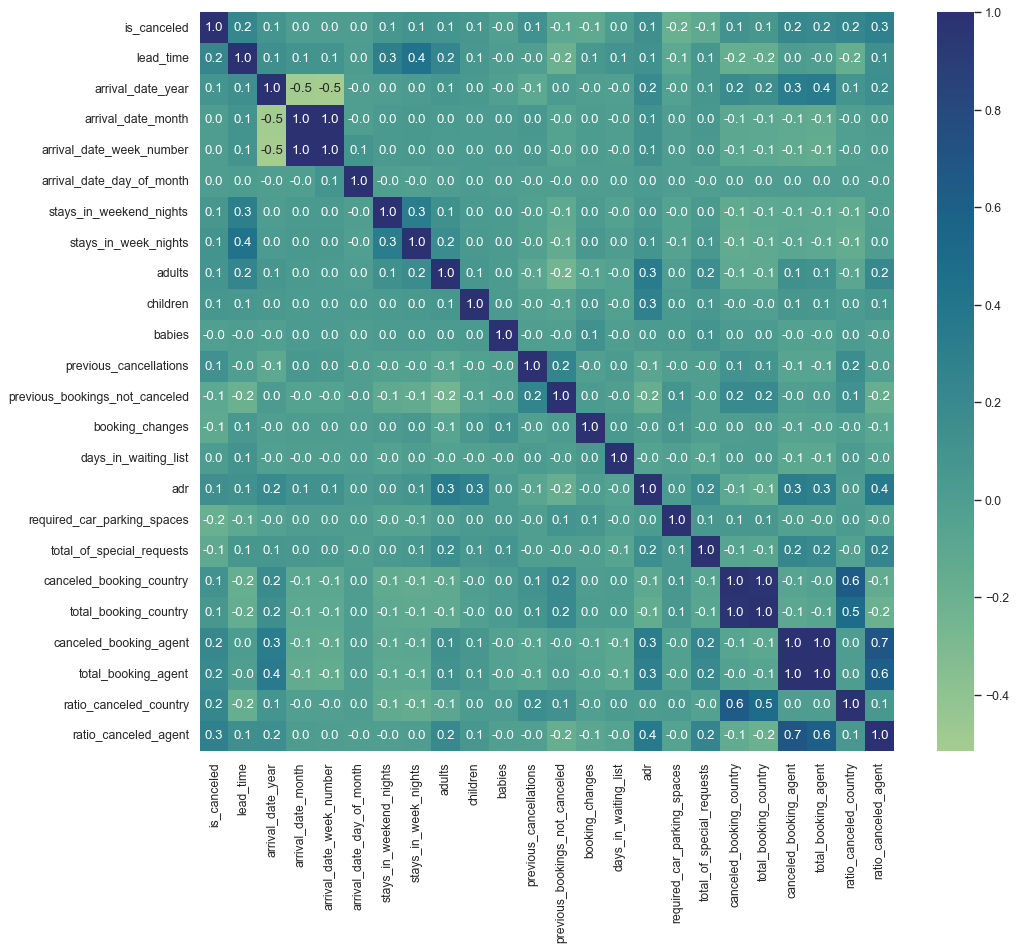

In [6]:
# Spearman correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1f', cmap='crest')

**[TBU]**
Based on the above graphs, there are several key takeaways as follows:

> - There is a very strong relationship between *imdb_rating* and *total_votes*. Additionally, there is a strong relationship between *imdb_rating* and *viewership*.
> - There is strong relationship between *total_votes* and *viewership*.
> - There is a very strong relationship between *n_lines* and *n_words*.
> - There is strong relationship between *n_words* and *duration*.
> - *imdb_rating* is a nearly normal distribution.
> - *n_lines* and *n_directions* have a weak relationship.
> - *imdb_rating* and *n_lines*, *n_directions*, *n_words* and *n_speak_char* have virtually no relationship.

<img src="spearman_interpretation.png" width=600>

The image above provides a view of the Spearman correlation coefficient and what the correlation coefficients values mean (values which can be seen in the heatmap). Spearman correlation coefficient is a non-parametric correlation coefficient that measures montonic relationships rather than  linear relationships. Pearson's correlation also considers that the data is approximiately normally distributed which we are unsure about. It is also easier to consider a montonic relationship in our data rather than a linear relationship as some of our data might not represent any type of linear relationship. Spearmans correlation coefficient is therefore the better correlation coefficient to use to measure the correlation among our features. 

By scrutinizing the correlations above, we note weak correlations between the *is_canceled* and some of our features, and strong correlations among some features themselves. Since a weak correlation to the target implies that the variable of concern might be irrelevant, and a significant correlation within features suggests some redundant dimensions in the matrix, the visualization of correlations serves as a clue for future data selection.

#### 2.4.2 Categorical Features

*distribution_channel* has similar values to *market_segment*, while *reserved_room_type* has similar values to *assigned_room_type*. Therefore, we are going to only use *market_segment* and *assigned_room_type* because they contain more detailed values. We will also remove  In addition, we will also remove *meal* and *customer_type* because each column is highly dominated by one single value.

Market Segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
Distribution Channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
Assigned Room Type: ['C' 'A' 'D' 'E' 'G' 'F' 'I' 'B' 'H' 'L' 'K']
Reserved Room Type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']


Text(0, 0.5, 'Total Rows (%)')

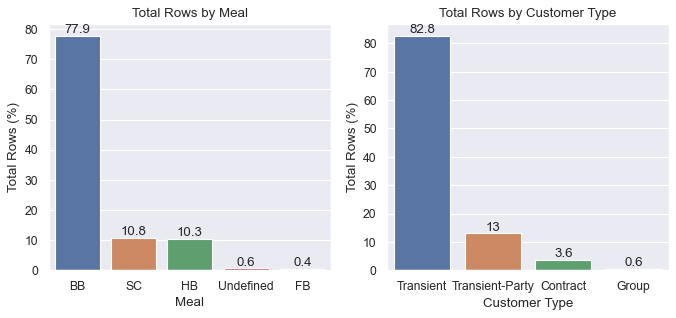

In [7]:
print(f'Market Segment: {df["market_segment"].unique()}')
print(f'Distribution Channel: {df["distribution_channel"].unique()}')
print(f'Assigned Room Type: {df["assigned_room_type"].unique()}')
print(f'Reserved Room Type: {df["reserved_room_type"].unique()}')

# Total rows by meal and customer_type
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# meal
sns.barplot(pd.DataFrame(np.round(df['meal'].value_counts()/len(df)*100, 1)).reset_index(),
                         x='index', y='meal', ax=ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Total Rows by Meal')
ax[0].set_xlabel('Meal')
ax[0].set_ylabel('Total Rows (%)')

# customer_type
sns.barplot(pd.DataFrame(np.round(df['customer_type'].value_counts()/len(df)*100, 1)).reset_index(),
                         x='index', y='customer_type', ax=ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Total Rows by Customer Type')
ax[1].set_xlabel('Customer Type')
ax[1].set_ylabel('Total Rows (%)')

### <a id=25> 2.5. Feature Selection and Scaling </a>

#### 2.5.1 Feature Selection

Based on the previous section, we will remove numerical features that are highly correlated with each other and features that only have weak correlation to our label *is_canceled*. In addition, we will also remove any categorical feature that has high cardinality, contains similar value as other categorical column, or is highly dominated by one value.

In [8]:
removed_cols = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date',
                'canceled_booking_country', 'canceled_booking_agent', 'meal',
                'country', 'distribution_channel', 'agent', 'reserved_room_type',
                'customer_type', 'arrival_date', 'booking_date']

#### 2.5.2 Feature Scaling

The following section standardizes the numerical data and one hot encodes the categorical data. The following `preprocess` function is defined to support this process:
- Oversampling data 
- Standardizes the numerical data and one hot encodes the numerical data.

**[TBU]**
The following function `preprocess` is the finalization of our data processing. Essentially the function has two main goals, to standardize the numerical values and to one hot encode the categorical values. However, this function also creates the pipeline for our model. The following is how each part of the pipeline is created:

1. **num_pipe**: This is where numerical values are scaled and standardized.

    * `SimpleImputer`: This is used to complete any missing values in the dataset. Particularly, the mean value of the numerical data is used to fill in missing values. Since the dataset is not large, a median or most frequent value would not be as appropriate as a the mean, since a median or most frequent number of the dataset may not represent the data well when filling in missing values. Adding a constant would also provide poor estimation and is not as flexible for any datasets and would require estimating the value based on assumptions of the data.
    * `StandardScaler`: This scales all the numerical data by subtracting the mean and dividing by the standard deviation of the column. This allows all the numerical data to be normalized and therefore future computations and model fitting will be more consistent.
    * `PowerTransformer`: This ensures that the data is closer to a Gaussian-like distribution. Each feature will be closer to a standard normal distribution. In particular, the yeo-johnson method is used as it accommodates for positive and negative values in our columns. Box-cox is another option, however, this only includes positive values. Therefore, yeo-johnson is the more flexible method and is preferred.

2. **cat_pipe**: This is the part of the pipleine that endoces the categorical data.

    * `OneHotEncoder`: This class is used to one hot encode our data.

3. **pipeline**: This sets up the pipeline for the entire model. There are many parts of this pipeline, they are all explained below:

    * scaling: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "scaling" in our pipeline, we are only referring to the part of the pipeline **num_pipe** which contains our numerical data. The other features, which are categorical, will be skipped but still included in the rest of the pipeline. 
    * encode: Here, the `ColumnTransformer` is used which specifies that when we use the keyword "encode" in our pipeline, we are only referring to the part of the pipeline **cat_pipe** which contains our categorical data. The other features, which are numerical will be skipped but still included in the rest of the pipeline.
    * model: This is where our final classification model will be placed in the pipeline.

In [9]:
def preprocess(model, num_cols, cat_cols, cols_preserved):
    """
    Parameters
    ----------
    model: machine learning model (sklearn model).
    num_cols: numerical columns that are going to be scaled (list).
    cat_cols: categorical columns that are going to be encoded (list).
    
    Returns
    -------
    pipeline: sklearn pipeline.
    """
    
    num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('num_scale', StandardScaler()),
    ('num_transform', PowerTransformer(method='yeo-johnson'))
    ])
    
    cat_pipe = Pipeline([
    ('cat_encode', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    pipeline = Pipeline([
    ('transform', ColumnTransformer([
        ('num_cols', num_pipe, num_cols),
        ('cat_cols', cat_pipe, cat_cols)])),
    ('model', model)
    ])

    return pipeline

## <a id=3> 3. Model Fitting and Tuning </a>

**[TBU]**
This section defines the regression model that will be used to fit and make the prediction about what features might provide the best new episode of The Office (US) based on the IMDB rating. There are multiple functions employed to help fit the model and to help demonstrate the features that will contribute to a higher IMDB rating. The model used is the Random Forest Regressor, as this provides the best RMSE and an overall better $R^2$ score. This regression model was also determined by testing other models and investigating which models would produce the best results and which models would have less underfitting or overfitting. Overall the Random Forest Regressor turned out to be the best model. The features used, validation, and hyperparameter tuning are all presented in this section of the report. 

- [**3.1. Testing Models**](#31): Describes which other models were tested and why they were not used.
- [**3.2. Model Explanation**](#32): A high level overview of what the Random Forest Regressor is.
- [**3.3. Model Preparation**](#33): Functions are created to ensure that the model can be fitted and hyperparameters can be tuned.
- [**3.4. Oversampling**](#34): Oversample minority class to handle imbalanced data.
- [**3.5. Model Fitting**](#35): Fitting the model to our data.
- [**3.6. Our Model Explained**](#36): An explanation of our specific model and it's predictive capability and performance factors.

### <a id=31> 3.1 Testing Models </a>

**[TBU]** <-- Try: LogisticRegression, SVM Classifier, Decision Tree Classifier

The following explains which models were tested, the results from each model, and why they were not used:

1. **Linear Regression**: Linear regression was the first model to be tested. The model fit the training data, but with an RMSE of approximately 0.38. This is not particularly high, as we would prefer the RMSE to be approximately 0-0.25. There are two other reasons that this model was not chosen. Firstly, the data is not linear. Linear regression, by it's name, works best for data that is linear, and judging by our feature correlation we can see that few of the features (particularly those related to IMDB rating) are not linear. Secondly, linear regression appears to overfit the data. The $R^2$ score is approximately 0.79, whereas the $R^2$ value for the testing set is approximately 0.58. This means the data is fitting the training data well, but when given new datasets, it's performance is mediocre.
2. **Lasso Regression**: After the trial for linear regression, we attempted to introduce a penalty on the absolute values of the coefficients to the objective function of the standard linear regression, originated from the  idea of Lasso regression. The penalty terms in this model are utilized to drive some coefficients to zero, essentially removing them from the model entirely, thereby making it less prone to overfitting. Nevertheless, the crux of the model is still a sophisticated linear correlation, which we have no reason to assume our model should adhere to. As we obtained an unsurprisingly compromising outcome, a $R^2$ score approximately 0.78 for the training set and a $R^2$ value up to 0.61 for the test set, we have also rejected this model.
3. **Decision Tree Regressor**: Next, we tried the decision tree regressor. this method may work better because the dataset does not have to be linear. The model results fit similar to linear regression with a RMSE of approximately 0.37. As mentioned above the ideal range for RMSE is 0-0.25. The value $R^2$ train scored very highly at 0.94 whereas the the test data scored 0.61. This shows again that the the model overfits the data but overall scores better than linear regression but still we will explore other methods. 

### <a id=32> 3.2 Model Explanation </a>

The following section will explain how Random Forest Regressor works. The specifics of our model are then explained in section 3.5.

The Random Forest Regressor is essentially multiple Decision Tree models. To understand Random Forest Regressor, it is necessary to first understand Decision Trees, specifically, Decision Tree Regressor models, as we are undergoing a regression model. In particular, a Decision Tree is simply nested if and else statements. Consider a dataset that has $N$ features with features $\{x_0, x_1,...,x_N\}$, $D$ data points, and one target variable with $D$ data points $\{y^0, y^1,..., y^D\}$. The dataset will be split into two categories at each node, starting at the root node. Each node will have a condition, meaning how the dataset will be split depending on the parent nodes condition (e.g. $x_2 \leq 1$). If you look at all $D$ data points and compare them with this condition, then all data points that meet this condition are in the left node of the split, and all the data points that do not meet the condition are in the right node (e.g. data points with a data point where $x_2 \leq 1$ will be in the right node, and the data points that do not meet this condition will be in the left node). But how do we determine what this condition is? This requires calculating variance reduction. Essentially, the program will run through every feature, and every value that each feature can take, and determine the maximum variance reduction for every possible split that the data set could create. This is done for every node, until the final depth of the tree. Since trees are also used for the Random Forest Regressor, the tree depth will be determined by the **RandomizedSearchCV class from sklearn using the parameter *max_depth***. The variance reduction is calculated as follows

$$Variance Reduction = Var(parent) - \sum{w_i}Var(child)$$

where $Var = \frac{1}{n}\sum_{i=0}^D{(y^i - \hat{y})^2}$, $Var(parent)$ is the variance of the parent node, $Var(child)$ is the variance of the child nodes, and $w_i$ are the weights which are simply the ratio of the number of data points in the child node, divided by the number of data points in the parent node (e.g. for $D$ datapoints, suppose that the split $x_i \leq 1$ results in $\frac{N}{3}$ on the left node which meets the condition and $\frac{2N}{3}$ on the right node. Then the weights would be $\frac{N/2}{N}$ and $\frac{2N/3}{N}$ respectively).

Eventually, the splits will end and there will be nodes with no condition, but rather, these final nodes (leaf nodes) are the data points that are finally split. Our data could be split into more than a single data point per leaf node, as we can have multiple data points per leaf node. Recall that each data point, $\{x_0^0,x_0^1,...x_0^D\},...,\{x_N^0,x_N^1,...,x_N^D\}$, has an associated output value $\{y^0,y^1,...,y^D\}$. Therefore, we end up with a single value (not necessarily a single data point) at each leaf node, which is the average of the output values $y$ at that particular leaf node. Essentially, when a new data point is added to try and create a prediction, the data point will run through the tree checking each condition and moving to the right or left node, until it ends up at a leaf node. Once it gets to a leaf node, the predicted value that is calculated is the average of the output values $y_i$ at that particular leaf node that was decided based on our training data set.

The issue with a regular decision tree is that it is highly sensitive to the training dataset. The model is accustomed quite well to the training dataset, so when new values enter, the optimal conditions are no longer optimal as the variance reduction values would be different for our test set than our training set. This leads to overfitting with our Decision Tree.

To reduce overfitting from the Decision Tree, a Random Forest Regressor is used. The main idea behind the Random Forest Regressor is to create multiple Decision Trees rather than just have the one. This is done by bootstrapping the dataset. Bootstrapping is where we randomly sample $D$ data points, with replacement, from the dataset and create $M$ new datasets. For example, suppose we just have $4$ data points, $\{d_1, d_2, d_3, d_4\}$. Suppose we choose a simple $M$ value, $M=2$. Then we will end up with $2$ datasets that might contain the following data points $\{d_1, d_3, d_3, d_2\}$, and $\{d_4, d_2, d_3, d_4\}$. Once these datasets are created, we choose a number of features to use for each of our $M$ new bootstrapped datasets. The number of features to use is usually the square root of the number of features on the training dataset rounded to the closest whole number. In our example, this would only be $1$ feature, since $\sqrt{2} \approx 1.4142$. Then the feature chosen for each dataset is also a random choice amongst all our features, with replacement. For our example, this could mean we end up with feature $x_1$ and $x_1$, or $x_2$ and $x_3$ for each dataset. 

Now that we have our new datasets created by bootstrapping and our randomized feature selection, we can finally create our forest of decision trees. Each bootstrapped dataset is fitted to the training dataset independently (which is fitted as a regular decision tree described above), which produces $M$ decision trees that each are trained on their respective bootstrapped dataset. In our model we use **RandomizedSearchCV to determine the optimal number $M$ of these datasets, which is also the number of decision trees used, particularly, this is the parameter *n_estimators* in the RandomForestRegressor class in sklearn**. Now, when a new data point is passed through our model, it enters each decision tree individually and each decision tree produces a result. Recall that the result for a decision tree is the average of the outputted data points at that particular leaf node. Since we now have many decision trees, we simply take the average of all the decision trees results, and we have our final prediciton.

The Random Forest Regressor is still prone to overfitting, however, since there are many decision trees and they are all randomized in terms of data points and the features used, the Random Forest Regressor is able to reduce exposure to overfitting. We are taking the average of the result of these multiple trees as well, which further decreases the chances of overfitting. Additionally, we also limit the **max_depth** to 19 and use **5-fold Cross Validation** to reduce the overfitting. 

The snippet of one of our decision trees is provided below:

<img src="snippet_tree.png" width=800 style="float: left;">

### <a id=33> 3.3 Model Preparation </a>

The following section provides preparation for the model that includes oversampling to handle imbalanced data.

The following function `split` splits the data into training and testing. Particularly we stratify the data to ensure that both the training and testing sets have same proportion of both classes. Based on the observation, the ratio of not canceled to canceled is 73:27, which indicates that our data is slightly imbalanced. This might cause the model to produce a high number of false negatives because it learns more about uncancelled transactions compared to the cancelled ones. However, we also want the model to still reflect the actual facts that there are more uncancelled transactions rather than canceled and reduce the possibility of false positive; therefore, we will oversampling data to make the ratio of not cancelled to cancelled becomes 60:40, which we assume as an appropriate number.

In [10]:
def split(df, label):
    """
    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    label: target column (string).
    
    Returns
    -------
    X_train_res: training dataset after oversampling (pd.DataFrame).
    X_test_res: testing dataset after oversampling (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    """ 
    X = df.drop(columns=label)
    y = df[label]
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=df[label + ['hotel']])
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
    # Oversampling
    df_train = pd.concat([X_train, y_train], axis=1)
    
    # Total rows by class before oversampling
    sns.barplot(pd.DataFrame(np.round(df_train['is_canceled'].value_counts()/len(df_train)*100, 1)).reset_index(),
                             x='index', y='is_canceled', ax=ax[0])
    ax[0].bar_label(ax[0].containers[0])
    ax[0].set_title('Total Rows by Class before Oversampling')
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Total Rows (%)')

    oversample = RandomOverSampler(sampling_strategy=4/6, random_state=42)
    X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

    # Total rows by class after oversampling
    df_train_res = pd.concat([X_train_res, y_train_res], axis=1)
    sns.barplot(pd.DataFrame(np.round(df_train_res['is_canceled'].value_counts()/len(df_train_res)*100, 1)).reset_index(),
                             x='index', y='is_canceled', ax=ax[1])
    ax[1].bar_label(ax[1].containers[0])
    ax[1].set_title('Total Rows by Class after Oversampling')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Total Rows (%)')
    
    return X_train_res, X_test, y_train_res, y_test

**[TBU]**
The following function `model_fit` is where the model is fitted and tested. The model is trained with hyperparameters that are identified by *RandomizedSearchCV*, which will run the model through the parameters given, and identify what hyperparameters will propduce the best model. The model is then fitted to the training data and testing data. The function will also output the mean absolute error, $R^2$ value, and root mean squared error to help determine whether the model is a good fit for the data. Ideally, for each metric, we are looking for the following values based on our data:

- *RMSE*: Between 0.0-0.25
- *MAE*: Between 0.0-0.25
- *$R^2$*: Between 0.7-1.0

The function will also plot the training and testing data along with the Random Forest Regressor line to show visually if our model will fit our data. 

In [11]:
def model_fit(pipeline, X_train, X_test, y_train, y_test):
    """
    Parameters
    ----------
    pipeline: pipeline that incorporates feature selection & scaling (sklearn.pipeline).
    X_train: training dataset (pd.DataFrame).
    X_test: testing dataset (pd.DataFrame).
    y_train: training label (pd.Series).
    y_test: testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn.pipeline).
    """
    # Run model
    # Randomized search of Random Forest's hyperparameters, using 3 fold cross validation
    params = {
              'model__n_estimators': range(100, 300, 20),
              'model__max_depth': range(1, 20, 1)
             }
    
    model = RandomizedSearchCV(pipeline, params, n_iter=30, random_state=42,
                               scoring='recall', cv=5, verbose=0, n_jobs=-1)

    # Fit the grid search model
    model.fit(X_train, y_train.values.ravel())
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    
    # Plot Evaluation metrics
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    pred_train = best_estimator.predict(X_train)
    sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Train | Recall Score: {recall_score(y_train, pred_train):.3f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Test
    plt.subplot(122)
    pred_test = best_estimator.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Test | Recall Score: {recall_score(y_test, pred_test):.3f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot ROC AUC
    plt.figure(figsize=(12, 5))
    
    # Train
    plt.subplot(121)
    prob = model.predict_proba(X_train)[:, 1]
    fpr, tpr, t_roc = roc_curve(y_train, prob)
    plt.plot(fpr, tpr, 'b-')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Train ROC_AUC: {auc(fpr, tpr):.3f}', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    # Test
    plt.subplot(122)
    prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, t_roc = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, 'b-')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Test ROC_AUC: {auc(fpr, tpr):.3f}', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    return best_estimator

The objective of `show_feature_importances` function is to identify the top k features that impact the model performance the most. `RandomForestClassifier` has *feature_importances_* attribute that provides a list of all features with the importance score ranging from 1 to 0. The logic behind the score calculation is *permutation_importance* class from sklearn that are described as follows:

1. First, the model will fit all the features and make prediction to produce a scoring that is called baseline scoring.
2. Then, one feature will be removed and fitted into the model. The difference of the score produced by this current model and the baseline scoring is the importance score of this feature. In short, permutation importance indicates how impactful a feature is towards the model prediction.
3. Step (2) will be repeated for all the features in the training dataset.

In [12]:
def show_feature_importances(pipeline, num_cols, cat_cols, topk=10):
    """
    Parameters
    ----------
    pipeline: pipeline with the best estimator for the model (sklearn.pipeline).
    top_k: top k highest features (default_value = 10) (int).
    """
    # Color palette
    colors = sns.light_palette('seagreen', topk, reverse=True)
    
    # Get topk highest features
    df_feature = pd.DataFrame({'name': num_cols + list(final_pipeline['transform'].transformers_[1][1].get_feature_names_out()),
                               'importance': pipeline['model'].feature_importances_}).sort_values('importance', ascending=False)
    df_feature = df_feature.head(topk)
    
    # Plot
    plt.figure(figsize=(8, 3))
    sns.barplot(df_feature, x='importance', y='name', palette=colors)
    plt.title(f'{topk} Most Important Features')

### <a id=34> 3.4 Model Fitting </a>

**[TBU]** The following section describes how the model is executed. Note that this only describes the code that is executed to perform the model. The explanation of the Random Forest Regressor is given in section 3.4, and the explanation of the specific model used is explained in section 3.5. 

The following code is where the model, Random Forest Regressor is implemented. The following bullet points explain the code. **Note: The following text does not explain the Random Forest Regressor model, that is explained below the following code snippet.**

- The label is assigned to our *imdb_rating* as this is our output variable y in our data.
- We assign the stratify to the *rating_cat* column in our dataset, which is the *imdb_rating* categories created in section 2.2.
- A list *all_cols* which is all the columns (features) of our dataset excluding our output (*imdb_rating*) and the rating categorical columns.
- A list *remove_cols* contains feature names for features that will be removed from our dataset. These features are removed due to low correlation with *imdb_ratings*, or due to high correlation with each other and therefore other features can be used. For example, the features *n_words* and *n_speak_char* are highly correlated with *n_lines*, where *n_lines* is a numerical feature we keep. 
- The categorical column (feature) names are all assigned to the list *cat_cols*. This is so that when we input them into our model we can encode them with the preprocess function.
- A list *num_cols* of feature names is created to track only the numerical features in the dataset. This is done by subtracting the list *all_cols* mentioned above with the list *cat_cols*, thereby only ending up with the numerical features we wish to use and scale.
- A list of feature names *col_preserved* is created so that within the pipeline, and thereby the preprocess function, these features will not have PCA performed on them as they have high correlation with the columns *imdb_rating*. The specific correlations of these features can be seen in section 2.4.3.
- Then the data is split into training and testing set using the `split` function. This also stratifies our training and test set to ensure that both the training and test datasets contain an roughly even amount of imdb_ratings. E.g. It would be possible that, without stratification, there would be imdb_ratings of only value 7.0 or lower in the training set and of 7.0 and higher in the testing set, resulting in overfitting. 
- Then the model is finally initiated, with parameter *random_state*=42, to ensure that our code is reproduceable.
- Then the pipeline is created with the `preprocess` function (which is explained in section 2.6).
- The function `model_fit` is then called (the function is explained above).
- Finally, the feature importances are shown.


In [ ]:
# Label for our dataset
label = ['is_canceled']

# Categorical columns that are going to be encoded
cat_cols = ['hotel', 'market_segment', 'is_repeated_guest', 'res_assign',
            'deposit_type', 'assigned_room_type']

# Numerical columns that are going to be scaled
num_cols = [x for x in df.columns if not x in label + cat_cols + removed_cols]

X_train, X_test, y_train, y_test = split(df[num_cols + cat_cols + label], label=label)

model = RandomForestClassifier(random_state=42)
pipeline = preprocess(model, num_cols, cat_cols, [])
final_pipeline = model_fit(pipeline, X_train, X_test, y_train, y_test)

### <a id=35> 3.5 Our Model Explanation </a>

Our model, using the Random Forest Regressor, is executed above and the results from the model are shown. This section will discuss the specifics of our model and the final outcome. Pariticularly, this section will detail the metrics/scores produced, hyparameter tuning, graphical representations of the predicted vs. actual data, residuals, prediction intervals and feature importance. This section is organized as follows:

- [**3.5.1. Model Hyperparameters**](#a-id351-351-model-hyperparameters-a)
- [**3.5.2. Model Metric/Scores**](#a-id352-352-model-metricsscores-a)
- [**3.5.3. Model Graphical Representations**](#a-id353-353-model-graphical-representations-a)
- [**3.5.4. Model Feature Importance**](#a-id354-354-model-feature-importance-a)
- [**3.5.5. Positive and Negative Feature Correlation**](#355)

#### <a id=351> 3.5.1 Model Hyperparameters </a>

The following discusses the three hyperparameters that we have tuned for the Random Forest Regressor using the RandomizedSearchCV. Below we examine each hyperparameter:

1. *n_estimators*: The second hyperparameter we tune is *n_estimators*. Recall that in section 3.2 it is mentioned that *n_estimators* is the number of decision trees in our forest created by Random Forest Regressor. The RandomizedSearchCV takes values 100 to 300 in increments fo 20, meaning that 10 different values can be randomly selected to determine the optimal number of trees. Our model determines that the optimal number of decision trees to create is 160 for our dataset. As mentioned before, this means that our dataset is bootstrapped into 160 datasets, where each dataset will be individually fitted, creating 160 decision trees.
2. *max_depth*: The third and final hyperparameter that is tuned in *max_depth*. This is also mentioned in section 3.2, but essentially the *max_depth* is how deep our decision trees in our forest can go. This means how many levels of nodes we can have in our forest at most. Particularly, RandomizedSearchCV randomly takes values from 1 to 20 to determine our optimal model. Given the optimal forest depth of 14, no more than 14 levels of nodes produce the optimal preditictive value.

#### <a id=352> 3.5.2 Model Metrics/Scores </a>
**[TBU]**
In section [3.1](#31) we tried and tested Linear Regression and Decision Tree regressor however both did not fit as well as Random Forest Regressor. Our scores for our models are as follows with:

| Metric  | Train Score  | Test Score | Ideal range  |
|---|---|---|---|
|  RMSE | 0.1249  |  0.2466 | 0-0.25  |
|  MAE | 0.0894  | 0.2071  |  0-0.25 |
| $R^2$ |  0.9415 | 0.8288 |  0.7-1 |

The slight difference in the test and train scores could be explained by the model being slightly overfitting. However, we have controlled the *max_depth* in the Random Forest Regressor model and used **5-fold Cross Validation** to reduce this. Our suggestion to further improve our model is to integrate more features, such as the budget, the expenses on advertising, the number of jokes, and the time of each main character in an episode.

#### <a id=353> 3.5.3 Model Graphical Representations </a>

**[TBU]**
The following discusses the three graphs that are produced above. This excludes the feautre importance which is explained below:

1. **Actual vs. Prediction Graph**: This plot shows how the actual *imdb_ratings* compare to the predicted/fitted data from our training set (graph on the left) and testing set (graph on the right). Ideally, for this type of graph, if the model is perfect, all points will fall onto the diagonal line (dotted line in our graphs). It is noticable that in the training graph (left) that the data points fall near to the diagonal line, indicating that our actual imdb_rating and the predicted imdb_ratings are close to equal for each data point. This results in a higher $R^2$ value of $0.941$. However, we do see that in the testing data, our data points are slightly more dispered away from the diagonal line, meaning that the testing data predictions and actual values for *imdb_ratings* are not always equal for each data point. This of course means a lower $R^2$ score of $0.829$. As explained above, this means the model is overfitting slightly.
2. **Residual Graph**: These graphs plot the residuals of our output data points. Recall that the residual is the difference between the actual imdb_rating and the predicted *imdb_rating* from our training (left) and testing (right) dataset. Therefore, when we plot our output variable's(*imdb_rating*'s) predicted value on the x-axis, and the residual on the y-axis. A perfect predicition model would see all the data points here fall on the line $y=0$. Much like the Actual vs Prediction Graph, this would mean that the actual values and the predicted values of the dataset would be equal, thus ensuring that our model would have perfect prediction performance. The training dataset (left), shows that the points are slightly dispersed around the line $y=0$, however, the furthest points from the line are approximately $0.25$ to $-0.55$. However, once again the testing set is more dispersed, indicating that our model is slightly overfitting. The highest and lowest values are approximately $0.38$ to $-0.57$. However, this dispersion of our training and testing dataset is not greatly different for our data. 
3. **Confidence Interval Graph**: This graph shows the error in our predictions specifically for the testing set, as we want to evaluate the predicitions for new data. It is noticable that the data at lower scores generally has higher error, whereas higher imdb_rating data points have slightly smaller error. This means that we are more confident to predict higher *imdb_ratings* than lower *imdb_ratings*. The error is computed based on infinitesimal jackknife variance as described in [2].

#### <a id=354> 3.5.4 Model Feature Importance </a>

The graph of features importances shows a significant correlation between *total_votes* and imdb_rating of approximately 0.59. This is not suprising given that people are more likely to watch a higher rated episode and therefore vote. Suprisingly, *n_lines* was second most important, the are several possible explanations for this such as the show is more enteraining with lots of dialogue and therefore more jokes. Or that physical interactions with less diaglogue is more entertaining. In conclusion, these are just theories and we lack the data to explain this. However, the next section we will explore the postive and negative importance of each variable to understand the actual impact of the parameters.

In [ ]:
show_feature_importances(final_pipeline, num_cols, cat_cols, topk=5)

## <a id=4> 4. Discussion and Conclusions </a>


**[TBU]**
Overall, we combined two datasets to retrieve data such as episode name, the name of writers, directors, main characters, and guest stars; total votes, air date, number of spoken lines, number of lines containing a stage direction, number of dialog words, number of different characters with spoken lines, viewership, and duration. By analyzing the existing data, we can gain other information such as the rating of previous episode, the average, lowest, and highest rating by writers, directors, main characters, and guests stars; how good/bad the writers, directors, main characters, and guest stars compared to the average (calculated by taking the difference between the rating obtained and average of rating), the popularity rate of episode name, writers, directors, main characters, and guest stars; as well as the year and month when the episode is aired.

To generate a prediction and gain insights on which factors contribute the most to the imdb rating, we use Random Forest Regressor model. In short, Random Forest Regressor is a group of decision trees which consists of if-else statements to define the imdb rating based on some specific criterias. This model is used because we have identified that there is no linear relationship between variables or combination of variables to imdb rating. Random Forest Regressor can handle this very well because it does not require the assumption that the variables/combination of variables have a linear relationship with imdb rating.

Based on the result, our model is able to produce a relatively good prediction with an error of 0.24 in average. It is also depicted that our model is considerably better at predicting higher imdb rating (>=8) rather than the lower ones (<8). The top 4 features that impact our model's predictions the most are total votes, number of spoken lines, number of main characters, and highest rating by directors.

We will now look at internal variables seperating internal and external variables. We define internal variables as variables that NBC can predetermine and thus fix such as *n_lines*, *director*, and *main_chars*. External variables such as *total_votes* will not be considered because we can only speculate this after the episode airs and therefore there is a large uncertainty. However, we can still provide a recommendation such as focusing on advertisement to increase traction and therefore *total_votes* will be larger.

# **Recommendations**

**[TBU]**
Internal Variables:

- The optimal **spoken lines** for the new episode are between 378 and 460
- The **director** for the new episode can either be Ken Kwapis, Paul Feig, or Jeffrey Blitz; or combination of them. 
- For the **number of main characters**, we suggest that the new episode casts at least 15 people.

External Variables:
- The higher the popularity of the epsiode the better. Therefore we recommend as much advertising as possible to gain as traction for the episode as possible.

**Disclaimer:** This model is designed to give recomendations for the highest IMDB rating as possible for the reunion episode. Noteworthily there is a disparity between an episode's popularity and it's IMDB rating, and there is not enough evidence to buttress a solid correlation between them. However, a high-rated episode is likely to favour the popularity in general, so for those particularly interested in the popularity, you may use the IMDB rating as an index for popularity, and thus the favourable factors we have firgured out may help. 

## 5. References

[1] Aurelien Geron. 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd. ed.). O'Reilly Media, Inc.

[2] S. Wager, T. Hastie, B. Efron. "Confidence Intervals for Random Forests: The Jackknife and the Infinitesimal Jackknife", Journal of Machine Learning Research vol. 15, pp. 1625-1651, 2014